# Advanced examples

In this section we'll show several examples of usage of the `byteparsing` package for dealing with files combining ASCII and binary data.

## Parsing PPM files

To show how we can mix ASCII and binary data, we have an example where we parse Portable PixMap files (PPM). These files have a small ASCII header and the image itself in binary. The header looks something like this:

```
P6   # this marks the file type in the Netpbm family
640 480
256
<<binary rgb values: 3*w*h bytes>>
```

In [1]:
import numpy as np
from dataclasses import dataclass
from byteparsing import parse_bytes
from byteparsing.parsers import (
    text_literal, integer, eol, named_sequence, sequence, construct,
    tokenize, item, array,  fmap, text_end_by, optional)

The PPM header format allows for comments in the ASCII header.

In [2]:
comment = sequence(text_literal("#"), text_end_by("\n"))

We define a class that should contain all the data in the header.

In [3]:
@dataclass
class Header:
    width: int
    height: int
    maxint: int

Then we can construct a parser for this header, using `named_sequence` and `construct`.

In [4]:
header = named_sequence(
    _1 = tokenize(text_literal("P6")),
    _2 = optional(comment),
    width = tokenize(integer),
    height = tokenize(integer),
    maxint = tokenize(integer)) >> construct(Header)

We'll have to pass on the header information to the parser for the binary blob somehow, so we define a function.

In [5]:
def image_bytes(header: Header):
    shape = (header.height, header.width, 3)
    size = header.height * header.width * 3
    return array(np.uint8, size) >> fmap(lambda a: a.reshape(shape))

ppm_image = header >> image_bytes

Let's test this on a sample image, and ignore the fact that `PIL` has a perfectly good parser for PPM files itself.

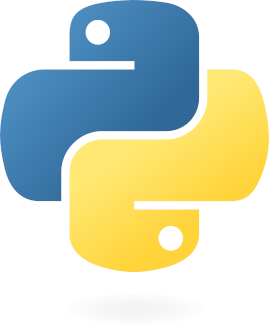

In [6]:
raw_data = open("python-logo.ppm", "rb").read()
image = parse_bytes(ppm_image, raw_data)

from PIL import Image
Image.frombytes(mode="RGB", size=(image.shape[1], image.shape[0]), data=image)

## Parsing PLY files

PLY is a file format storing 3D polygonal data that has support for both ASCII and binary formats. Some references: [Wikipedia entry](https://en.wikipedia.org/wiki/PLY_(file_format)) and [Paul Bourke's pages](http://paulbourke.net/dataformats/ply/). The specification of the PLY format is a bit vague and allows for liberal interpretation and custom user defined fields. We take a look at the example on Paul Bourke's page:

```
ply
format ascii 1.0           { ascii/binary, format version number }
comment made by Greg Turk  { comments keyword specified, like all lines }
comment this file is a cube
element vertex 8           { define "vertex" element, 8 of them in file }
property float x           { vertex contains float "x" coordinate }
property float y           { y coordinate is also a vertex property }
property float z           { z coordinate, too }
element face 6             { there are 6 "face" elements in the file }
property list uchar int vertex_index { "vertex_indices" is a list of ints }
end_header                 { delimits the end of the header }
0 0 0                      { start of vertex list }
0 0 1
0 1 1
0 1 0
1 0 0
1 0 1
1 1 1
1 1 0
4 0 1 2 3                  { start of face list }
4 7 6 5 4
4 0 4 5 1
4 1 5 6 2
4 2 6 7 3
4 3 7 4 0
```

We see a header that is always ASCII encoded. The header specifies a list of *elements*, each containing a list of *properties*. The listed elements determine how to parse the data section of the PLY file. The data section maybe encoded in ASCII or binary.

In [7]:
from __future__ import annotations
from typing import Optional
from dataclasses import dataclass
from functools import partial
import numpy as np
import pprint

from byteparsing import (parse_bytes, Parser, parser)
from byteparsing.parsers import (
    sequence, named_sequence, choice, optional, value, repeat_n,
    text_literal, char, text_one_of, text_end_by,
    byte_none_of, byte_one_of,
    flush, flush_decode,
    push, pop, char_pred,
    many, some, many_char, some_char, many_char_0, some_char_0,
    integer, scientific_number, array, binary_value,
    fmap, construct)

pp = pprint.PrettyPrinter(indent=2, width=80)

### Header

The header starts with a "magic number", a line containing `ply`.

In [8]:
eol = choice(text_literal("\n"), text_literal("\n\r"))
ply_magic_number = sequence(text_literal("ply"), eol)

The second line indicates which variation of the PLY format this is. We will store header information in data classes and enums.

In [9]:
from enum import Enum

class PlyFormat(Enum):
    ASCII = 1
    BINARY_LE = 2
    BINARY_BE = 3
    
    @staticmethod
    def from_string(format_str: str) -> PlyFormat:
        if format_str == "ascii":
            return PlyFormat.ASCII
        if format_str == "binary_little_endian":
            return PlyFormat.BINARY_LE
        if format_str == "binary_big_endian":
            return PlyFormat.BINARY_BE
        else:
            raise ValueError(f"Unrecognized format string: {s}")

Since each item in the header is seperated by a newline, we need a `tokenize` function that doesn't skip newlines. From that we can define what we may consider to be a `word` in a PLY header. We `flush` the cursor, expect a `ascii_alpha` character (words don't start with numbers) and then many characters that are letters, numbers or underscores. At the end we `flush` the cursor again, decoding to a Python string. We see here both `many_char` and `many_char_0` being used: `many_char` automatically flushes the cursor before and after which is not what we want when parsing a word. In fact, the only thing `many_char_0` does, is to move the cursor end until the given parser no longer matches the input.

In [10]:
ascii_alpha = char_pred(lambda c: 64 < c < 91 or 96 < c < 123)
ascii_num = char_pred(lambda c: 48 <= c < 58)
ascii_alpha_num = choice(ascii_alpha, ascii_num)
ascii_underscore = char(95)


def tokenize(p: Parser) -> Parser:
    return sequence(p >> push, many_char(text_one_of(" ")), pop())

word = sequence(
    flush(), ascii_alpha, many_char_0(choice(ascii_alpha_num, ascii_underscore)),
    flush_decode())

The format line specifies the used data encoding: one of `ascii`, `binary_little_endian` or `binary_big_endian`, and a version number. The version number is always "1.0".

In [11]:
ply_format = named_sequence(
    _1 = tokenize(text_literal("format")),
    format_str = tokenize(word),
    _2 = sequence(tokenize(text_literal("1.0")), eol)) \
>> construct(PlyFormat.from_string)

In [12]:
parse_bytes(ply_format, b"format binary_little_endian 1.0\n")

<PlyFormat.BINARY_LE: 2>

Comments may be placed in the header by using the word comment at the start of the line. Everything from there until the end of the line should then be ignored.

In [13]:
ply_comment = sequence(
    tokenize(text_literal("comment")), flush(),
    text_end_by("\n") >> push, optional(char("\r")), pop())

Now we need a parser for a data type, and given a data type we need to be able to parse that data either in ASCII or binary. There are two classes of types: primitive types and list types.

In [14]:
ply_type_table = {
    "char": "int8",
    "uchar": "uint8",
    "short": "int16",
    "ushort": "uint16",
    "int": "int32",
    "uint": "uint32",
    "float": "float32",
    "double": "float64"
}

class PlyType:
    pass

@dataclass
class PlyPrimitiveType(PlyType):
    dtype: np.dtype
        
    @staticmethod
    def from_string(s: str) -> PlyPrimitiveType:
        sanitized_name = ply_type_table.get(s, s)
        return PlyPrimitiveType(np.dtype(sanitized_name))
    
    @property
    def byte_size(self) -> int:
        return self.dtype.itemsize
    
    def ascii(self) -> Parser:
        return sequence(
            flush(), some_char_0(byte_none_of(b"\n ")),
            many_char_0(byte_one_of(b"\n ")), flush(self.dtype.type))
    
    def binary(self) -> Parser:
        return binary_value(self.dtype)
    
@dataclass
class PlyListType(PlyType):
    size_type: PlyPrimitiveType
    value_type: PlyPrimitiveType
    
    def ascii(self) -> Parser:
        return self.size_type.ascii() >> partial(repeat_n, self.value_type.ascii())
    
    def binary(self) -> Parser:
        return binary_value(self.size_type.dtype) >> partial(array, self.value_type.dtype)

In [15]:
primitive_type = tokenize(word) >> fmap(PlyPrimitiveType.from_string)

list_type = named_sequence(
    _1=tokenize(text_literal("list")),
    size_type=primitive_type,
    value_type=primitive_type) >> construct(PlyListType)

ply_type = choice(list_type, primitive_type)

In [16]:
parse_bytes(ply_type, b"float float")

PlyPrimitiveType(dtype=dtype('float32'))

In [17]:
pp.pprint(parse_bytes(ply_type, b"list uint8 float"))

PlyListType(size_type=PlyPrimitiveType(dtype=dtype('uint8')), value_type=PlyPrimitiveType(dtype=dtype('float32')))


In [18]:
@dataclass
class PlyProperty:
    dtype: PlyType
    name: str

ply_property = named_sequence(
    _1=tokenize(text_literal("property")),
    dtype=ply_type,
    name=tokenize(word),
    _2=eol) >> construct(PlyProperty)

In [19]:
parse_bytes(
    ply_property,
    b"property float x\n")

PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='x')

In [20]:
end_header = sequence(text_literal("end_header"), eol)

In [21]:
@dataclass
class PlyElement:
    name: str
    size: int
    properties: List[PlyProperty]
        
    def ascii(self) -> Parser:
        single_item = named_sequence(
            **{p.name: p.dtype.ascii() for p in self.properties})
        return repeat_n(single_item, self.size)
    
    @property
    def afine(self) -> bool:
        return all(isinstance(p.dtype, PlyPrimitiveType)
                   for p in self.properties)
    
    def binary(self) -> Parser:
        if self.afine:
            compound_type = [(p.name, p.dtype.dtype) for p in self.properties]
            return array(compound_type, self.size)
        else:
            single_item = named_sequence(
                **{p.name: p.dtype.binary() for p in self.properties})
            return repeat_n(single_item, self.size)
    

ply_element = named_sequence(
    _1=tokenize(text_literal("element")),
    name=tokenize(word),
    size=tokenize(integer),
    _2=eol,
    properties=some(ply_property)) >> construct(PlyElement)

In [22]:
pp.pprint(
    parse_bytes(
        some(ply_element), 
        b"element vertex 8\nproperty float x\nproperty float y\nproperty float z\n" +
        b"element face 6\nproperty list uchar int vertex_index\n"))

[ PlyElement(name='vertex', size=8, properties=[PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='x'), PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='y'), PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='z')]),
  PlyElement(name='face', size=6, properties=[PlyProperty(dtype=PlyListType(size_type=PlyPrimitiveType(dtype=dtype('uint8')), value_type=PlyPrimitiveType(dtype=dtype('int32'))), name='vertex_index')])]


In [23]:
pp.pprint(parse_bytes(ply_element, b"element face 6\nproperty list uchar int vertex_index\n"))

PlyElement(name='face', size=6, properties=[PlyProperty(dtype=PlyListType(size_type=PlyPrimitiveType(dtype=dtype('uint8')), value_type=PlyPrimitiveType(dtype=dtype('int32'))), name='vertex_index')])


In [24]:
@dataclass
class PlyHeader:
    format: PlyFormat
    comment: List[str]
    elements: List[PlyElement]
        
    def parser(self) -> Parser:
        if self.format == PlyFormat.ASCII:
            return named_sequence(
                **{e.name: e.ascii() for e in self.elements})
        if self.format == PlyFormat.BINARY_LE:
            return named_sequence(
                **{e.name: e.binary() for e in self.elements})
        else:
            raise NotImplementedError()

ply_header = named_sequence(
    _1=ply_magic_number,
    format=ply_format,
    comment=many(ply_comment),
    elements=some(ply_element),
    _2=sequence(text_literal("end_header"), eol)) >> construct(PlyHeader)

def ply_data(header):
    return named_sequence(header=value(header), data=header.parser())

ply_file = ply_header >> ply_data

The following ASCII example is given on Paul Bourke's page.

In [25]:
ascii_example = b"""ply
format ascii 1.0
comment made by Greg Turk
comment this file is a cube
element vertex 8
property float x
property float y
property float z
element face 6
property list uchar int vertex_index
end_header
0 0 0
0 0 1
0 1 1
0 1 0
1 0 0
1 0 1
1 1 1
1 1 0
4 0 1 2 3
4 7 6 5 4
4 0 4 5 1
4 1 5 6 2
4 2 6 7 3
4 3 7 4 0
"""

In [26]:
pp.pprint(parse_bytes(ply_header, ascii_example))

PlyHeader(format=<PlyFormat.ASCII: 1>, comment=['made by Greg Turk', 'this file is a cube'], elements=[PlyElement(name='vertex', size=8, properties=[PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='x'), PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='y'), PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name='z')]), PlyElement(name='face', size=6, properties=[PlyProperty(dtype=PlyListType(size_type=PlyPrimitiveType(dtype=dtype('uint8')), value_type=PlyPrimitiveType(dtype=dtype('int32'))), name='vertex_index')])])


No for the fun part! The header that we read actually encodes the parser for the rest of the file!

In [27]:
pp.pprint(parse_bytes(ply_file, ascii_example))

{ 'data': { 'face': [ {'vertex_index': [0, 1, 2, 3]},
                      {'vertex_index': [7, 6, 5, 4]},
                      {'vertex_index': [0, 4, 5, 1]},
                      {'vertex_index': [1, 5, 6, 2]},
                      {'vertex_index': [2, 6, 7, 3]},
                      {'vertex_index': [3, 7, 4, 0]}],
            'vertex': [ {'x': 0.0, 'y': 0.0, 'z': 0.0},
                        {'x': 0.0, 'y': 0.0, 'z': 1.0},
                        {'x': 0.0, 'y': 1.0, 'z': 1.0},
                        {'x': 0.0, 'y': 1.0, 'z': 0.0},
                        {'x': 1.0, 'y': 0.0, 'z': 0.0},
                        {'x': 1.0, 'y': 0.0, 'z': 1.0},
                        {'x': 1.0, 'y': 1.0, 'z': 1.0},
                        {'x': 1.0, 'y': 1.0, 'z': 0.0}]},
  'header': PlyHeader(format=<PlyFormat.ASCII: 1>, comment=['made by Greg Turk', 'this file is a cube'], elements=[PlyElement(name='vertex', size=8, properties=[PlyProperty(dtype=PlyPrimitiveType(dtype=dtype('float32')), name

### The Stanford Bunny

Now that we have the capability to parse binary PLY files, we can load the Stanford Bunny. For visualisation purposes it helps to know that all faces in this file are triangles.

In [28]:
from pathlib import Path

bunny = parse_bytes(ply_file, Path("_static/stanford_bunny.ply").open(mode="rb").read())

In [29]:
vertices = bunny["data"]["vertex"].view((np.float32, 3))
triangles = np.array([row["vertex_indices"] for row in bunny["data"]["face"]])

In [30]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
# For interactive use: install ipympl and run:
# %matplotlib widget

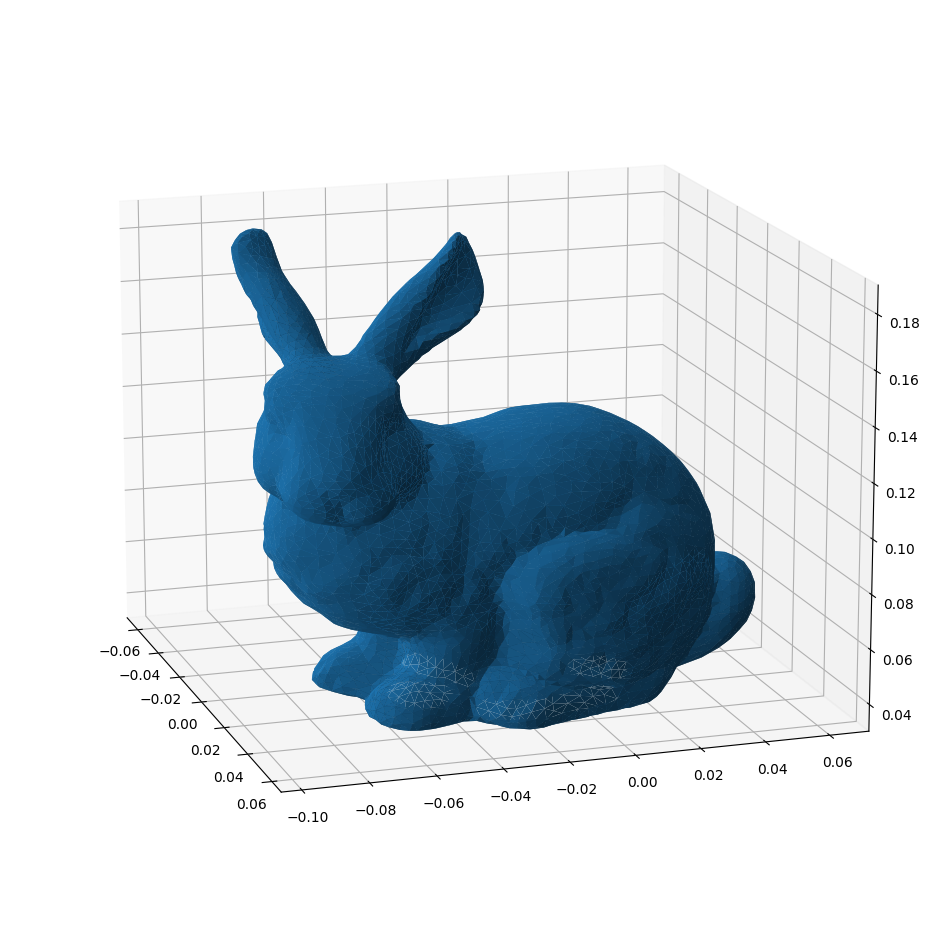

In [31]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection="3d")
ax.azim = -18
ax.elev = 15
ax.plot_trisurf(*vertices.T[[2,0,1]], triangles=triangles);

## Parsing Memory mapped OpenFOAM files

The final example is to read an OpenFOAM file as a memory mapped array. There are some details that need attention.

```python
import mmap
import numpy as np
from byteparsing import parse_bytes
from byteparsing.openfoam import foam_file

f = Path("pipeFlow/1.0/U").open(mode="r+b")
with mmap.mmap(f.fileno(), 0) as mm:
  content = parse_bytes(foam_file, mm)
  result = content["data"]["internalField"]

  <<do work ...>>

  del result
  del content
```

The content is returned in the form of a nested dictionary. The `"internalField"` item is a name that one often finds in OpenFOAM files. The `result` object is a Numpy `ndarray` created using a `np.frombuffer` call. Any mutations to the Numpy array are directly reflected on the disk. This means that accessing large amounts of data can be extremely efficient in terms of memory footprint.

The final two `del` statements are necessary to ensure that no reference to the memory-mapped data outlives the memory map itself, which is closed as soon as we leave the `with mmap ...` context.